In [345]:
import config
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import folium
import urllib
import regex as re
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt

# Retail Opportunity Inference from Nearby Cities
The purpose of this analysis is to determine new retail that should open the Church Hill neighborhood of Richmond, VA.  First we will broadly characterize Church Hill by grouping it with other neighborhoods with similar retail.  We can gather retail data on all the neighborhoods of Richmond and seven other nearby cities and perform machine learning clustering.  Once we have clusters of neighborhoods which have similar retail, we will deduce by elimination the categories missing from Church Hill but found in high frequency within its cluster.  

## 1 Data Collection

### 1.1 Geographic Data Collection using Google Geocoder
We start by collecting a list of neighborhoods and their latitude, longitude coordinates.  I've decided to look at all the neighborhoods of Baltimore, Charlotte, Charlottesville, Norfolk, Raleigh, Richmond, Virginia Beach, and Washington, DC.

In [53]:
#An empty dataframe to collect the neighborhood data.
neigh_df=pd.DataFrame(columns=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])

In [54]:
#A function to plot the neighborhoods on a map.
def map_neigh(city,zoom, radius):
    lat_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'].mean()
    lng_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'].mean()

    f = folium.Figure(width=650, height=450)
    city_map = folium.Map(location=[lat_center,lng_center], zoom_start=zoom).add_to(f)

    # add markers to map
    for x,y, name in zip(neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [x,y],
            radius=radius,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(city_map)  

    return city_map

#### 1.1.1 Acquire Baltimore, MD neighborhood data

In [55]:
#Scrape wikipedia to generate a list of baltimore neighborhood names
bmd_page = requests.get('https://en.wikipedia.org/wiki/List_of_Baltimore_neighborhoods').text
bmd_soup = BeautifulSoup(bmd_page,'html.parser')
bmd_neigh=[]
neigh_search = bmd_soup.find_all('li')
for x in neigh_search[14:312]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in bmd_neigh:
        bmd_neigh.append(name)
bmd_neigh[261]='West Federal Hill'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in bmd_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Baltimore, MD"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Baltimore','State':'MD','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  West Hill Square


In [56]:
map_neigh('Baltimore',zoom=11,radius=250)

In [57]:
neigh_df.loc[neigh_df.City=='Baltimore','Radius']=250

#### 1.1.2 Acquire Charlotte, NC neighborhood data

In [58]:
#Scrape wikipedia to generate a list of Charlotte neighborhood names
cnc_page = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Charlotte,_North_Carolina').text
cnc_soup = BeautifulSoup(cnc_page,'html.parser')
cnc_neigh=[]
neigh_search = cnc_soup.find_all('li')
for x in neigh_search[1:34]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cnc_neigh:
        cnc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cnc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlotte, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlotte','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [59]:
map_neigh('Charlotte',zoom=10,radius=700)

In [60]:
neigh_df.loc[neigh_df.City=='Charlotte','Radius']=700

#### 1.1.3 Acquire Charlottesville, VA neighborhood data

In [61]:
#Scrape wikipedia to generate a list of charlottesville neighborhood names
cva_page = requests.get('https://www.cvillepedia.org/List_of_Charlottesville_neighborhoods').text
cva_soup = BeautifulSoup(cva_page,'html.parser')
cva_neigh=[]
neigh_search = cva_soup.find_all('li')
for x in neigh_search[5:23]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cva_neigh:
        cva_neigh.append(name)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlottesville, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlottesville','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [62]:
map_neigh('Charlottesville',zoom=12,radius=400)

In [63]:
neigh_df.loc[neigh_df.City=='Charlottesville','Radius']=400

#### 1.1.4 Acquire Norfolk, VA neighborhood data

In [64]:
#Scrape wikipedia to generate a list of norfolk neighborhood names
norva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Norfolk,_Virginia').text
norva_soup = BeautifulSoup(norva_page,'html.parser')
norva_neigh=[]
neigh_search = norva_soup.find_all('li')
for x in neigh_search[0:49]:
    norva_neigh.append(x.text)
norva_neigh[19]='Huntersville'
norva_neigh[3]='Bowling Green'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in norva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Norfolk, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Norfolk','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name) 

In [65]:
map_neigh('Norfolk',zoom=11,radius=400)

In [66]:
neigh_df.loc[neigh_df.City=='Norfolk','Radius']=400

#### 1.1.5 Acquire Raleigh, NC neighborhood data

In [67]:
#Scrape wikipedia to generate a list of raleigh neighborhood names
rgh_page = requests.get('https://en.wikipedia.org/wiki/Raleigh,_North_Carolina_neighborhoods').text
rgh_soup = BeautifulSoup(rgh_page,'html.parser')
rgh_neigh=[]
neigh_search = rgh_soup.find_all('li')
for x in neigh_search[4:109]:
    rgh_neigh.append(x.text)
    
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rgh_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Raleigh, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Raleigh','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  Westlake


In [68]:
map_neigh('Raleigh',zoom=11,radius=400)

In [69]:
neigh_df.loc[neigh_df.City=='Raleigh','Radius']=400

#### 1.1.6 Acquire Richmond, VA neighborhood data.

In [70]:
#Scrape wikipedia to generate a list of rva neighborhood names
rva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Richmond,_Virginia').text
rva_soup = BeautifulSoup(rva_page,'html.parser')
rva_neigh=[]
neigh_search = rva_soup.find_all('li')
for x in neigh_search[7:112]:
    rva_neigh.append(x.text)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Richmond, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Richmond','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [71]:
map_neigh('Richmond',zoom=11,radius=400)

In [72]:
neigh_df.loc[neigh_df.City=='Richmond','Radius']=400

#### 1.1.7 Acquire Virginia Beach, VA neighborhood data

In [73]:
#Here is the list of Virginia Beach neighborhoods
vab_neigh=['Alanton', 'Aragona Village', 'Bay Colony', 'Bayside', 'Cape Henry', 'Chesapeake Beach', 
               'Croatan Beach', 'Great Neck Point', 'Green Run', 'Kempsville', 'Lago Mar', 'Larkspur', 
               'London Bridge', 'Lynnhaven', 'Newtown', 'The North End', 'Oceana', 'Ocean Park', 'Pembroke Manor',
               'Princess Anne', 'Pungo', 'Red Mill Commons', 'Sandbridge', 'Thalia', 'Thoroughgood']

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in vab_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Virginia Beach, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Virginia Beach','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [74]:
map_neigh('Virginia Beach',zoom=10,radius=800)

In [75]:
neigh_df.loc[neigh_df.City=='Virginia Beach','Radius']=800

#### 1.1.8 Acquire Washington, DC neighborhood data

In [76]:
#Scrape wikipedia to generate a list of washington, dc neighborhood names
wdc_page = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Washington,_D.C.').text
wdc_soup = BeautifulSoup(wdc_page,'html.parser')
wdc_neigh=[]
neigh_search = wdc_soup.find_all('li')
for x in neigh_search[11:153]:
    name= re.sub(r"(| )\([^()]*\)", "", x.text)
    if name not in wdc_neigh:
        wdc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in wdc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Washington, DC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Washington','State':'DC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [77]:
map_neigh('Washington',zoom=11,radius=250)

In [78]:
neigh_df.loc[neigh_df.City=='Washington','Radius']=250

In [79]:
#Save to csv file 
neigh_df.to_csv('neigh_df.csv',index=False)

In [28]:
neigh_df.shape

(747, 6)

We've collected 747 total neighborhoods from the eight cities we chose.

### 1.2 Retail Data Collection from Foursquare

Now we collect all retail venues found within a radius of each neighborhood collected above.  We chose the radius based on the map views above.

In [15]:
neigh_df=pd.read_csv('neigh_df.csv')

In [ ]:
#A function to retrieve nearby retail venue data with the foursquare api.
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(df):
    
    venues_list=[]
    for neigh, city, state, lat, lng , radius in zip(df['Neighborhood'], df['City'],df['State'], df['Neighborhood Latitude'], df['Neighborhood Longitude'], df['Radius']):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            config.foursquare_id, 
            config.foursquare_secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neigh, 
            city,
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(neigh, end='\r')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'City',
                  'State',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#Collect all the retail locations by executing the function defined above.
venues_df=getNearbyVenues(neigh_df)

In [279]:
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place
...,...,...,...,...,...,...,...,...,...
5735,Starmount,Charlotte,NC,35.141693,-80.868220,Park South Station Pool and Fitness Club,35.145354,-80.864310,Club House
5736,Starmount,Charlotte,NC,35.141693,-80.868220,On The Go Mart,35.143072,-80.875201,Gas Station
5737,Stonehaven,Charlotte,NC,35.155497,-80.763010,"Quality Grill Parts, LLC",35.156302,-80.761389,Business Service
5738,Stonehaven,Charlotte,NC,35.155497,-80.763010,Betty Boos Treats,35.155218,-80.756179,Bakery


We've collected data on 5740 venues.

In [132]:
#Save venue data to csv file
venues_df.to_csv('venues_df.csv',index=False)

## 2 Data Preparation

In [904]:
#Read neighborhood and venue data from csv files
venues_df=pd.read_csv('venues_df.csv')
venues_df.shape

(5740, 9)

There are some venues collected from foursquare with category listed as neighborhood, housing developement, beach, lake, river, or building.  We're going to get rid of each of these venues because they do not represent any kind of relevant retail venue.

In [905]:
#Remove venues with trivial categories
venues_df=venues_df[venues_df['Venue Category']!='Neighborhood'] 
venues_df=venues_df[venues_df['Venue Category']!='Housing Development'] 
venues_df=venues_df[venues_df['Venue Category']!='Building'] 
venues_df=venues_df[venues_df['Venue Category']!='Beach'] 
venues_df=venues_df[venues_df['Venue Category']!='Lake'] 
venues_df=venues_df[venues_df['Venue Category']!='River'] 
venues_df.shape

(5683, 9)

This removed 8 retail venues whose category was Neighborhood.

### 2.1 Count the number of retail locations in each neighborhood

In [906]:
#Make a column venue count which counts the number of venues in each neighborhood
neigh_df = venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False)['Venue'].count()
neigh_df.columns = ['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude','Neighborhood Venue Count']
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
0,10th & Page,Charlottesville,VA,38.035116,-78.493400,14
1,Abell,Baltimore,MD,39.324474,-76.610944,4
2,Adams Morgan,Washington,DC,38.921242,-77.043493,52
3,Alanton,Virginia Beach,VA,36.880667,-76.024684,5
4,Allendale,Baltimore,MD,39.291798,-76.675200,1
...,...,...,...,...,...,...
579,Woodmoor,Baltimore,MD,39.338440,-76.733028,1
580,Woodridge,Washington,DC,38.933000,-76.968034,2
581,Woolen Mills,Charlottesville,VA,38.020366,-78.456190,5
582,Wyman Park,Baltimore,MD,39.330870,-76.627553,22


We see that only 587 of the 747 neighborhoods have at least one retail location on record.  

In [907]:
neigh_df.loc[neigh_df.Neighborhood=='Church Hill']

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
102,Church Hill,Richmond,VA,37.53284,-77.416252,15


We also see that Church Hill has 15 retail locations on record.  Let's make a histogram of the venue counts of the 587 remaining neighborhoods.

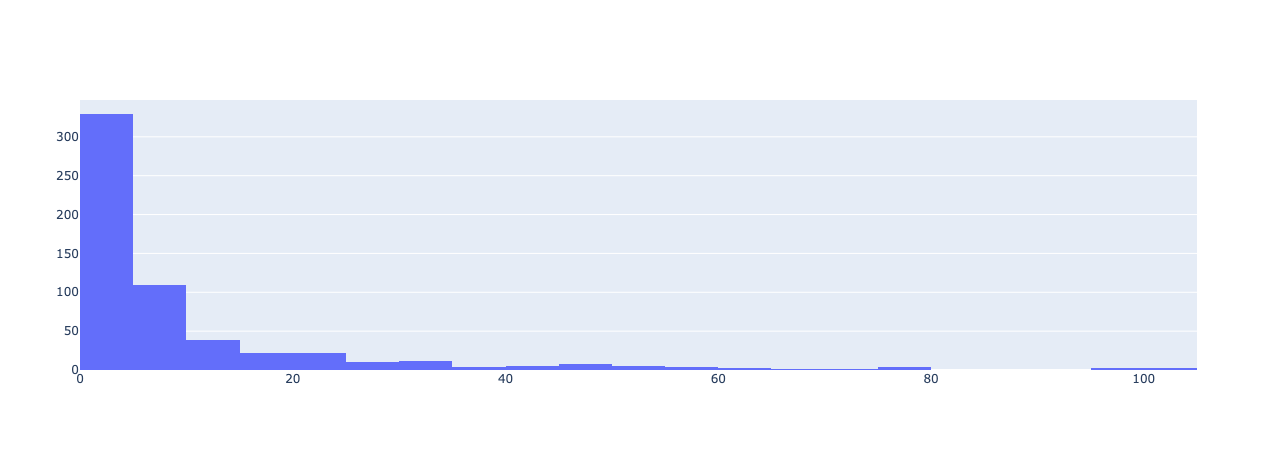

In [908]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=neigh_df['Neighborhood Venue Count'],xbins=dict( #
        start=0,
        end=105,
        size=5)))
fig.show()

There are 480 neighborhoods with less than 15 retail locations.  Since we are clustering to find similar neighborhoods, it would make sense to ignore these 480 neighborhoods with less than 15 retail locations.

### 2.2 Remove Neighborhoods with minimal retail

In [909]:
#add the venue count column to the venues_df
venues_df=venues_df.merge(neigh_df,on=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])
#Remove neighborhoods with less than 15 retail venues
venues_df = venues_df[(venues_df['Neighborhood Venue Count']>=15)]
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Venue Count
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café,23
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place,23
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega,23
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant,23
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place,23
...,...,...,...,...,...,...,...,...,...,...
5673,SouthPark,Charlotte,NC,35.148448,-80.830896,Gymboree,35.152143,-80.832488,Kids Store,100
5674,SouthPark,Charlotte,NC,35.148448,-80.830896,Dairy Queen,35.153833,-80.828647,Ice Cream Shop,100
5675,SouthPark,Charlotte,NC,35.148448,-80.830896,Planet Smoothie,35.152843,-80.832594,Smoothie Shop,100
5676,SouthPark,Charlotte,NC,35.148448,-80.830896,Aéropostale,35.153046,-80.832473,Clothing Store,100


We've removed 1859 retail venues by removing all the neighborhoods with less than 15 retail venues.

### 2.3 Create feature (dummy) columns for each retail category

In [910]:
#Make dummy columns on the venues_df
venues_df=pd.get_dummies(venues_df, columns= ['Venue Category'], prefix="", prefix_sep="") 
#Take the mean of each dummy column grouped by neighborhood to get the retail category frequency (percent)
neigh_df=venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False).mean().drop(labels=['Venue Latitude','Venue Longitude'],axis=1)
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,ATM,Accessories Store,Afghan Restaurant,African Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Adams Morgan,Washington,DC,38.921242,-77.043493,52,0.0,0.0,0.019231,0.0,...,0.0,0.0,0.0,0.0,0.019231,0.000000,0.0,0.0,0.0,0.000000
1,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,Arts District,Richmond,VA,37.543453,-77.438963,23,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,Bayside,Virginia Beach,VA,36.902925,-76.134380,34,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,Bellevue,Richmond,VA,37.590832,-77.457554,15,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,West Raleigh Historic District,Raleigh,NC,35.777619,-78.638765,78,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.012821
102,Westhampton,Richmond,VA,37.574101,-77.514645,19,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.052632
103,Wilder's Grove,Raleigh,NC,35.798804,-78.564528,19,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
104,Willow Lawn,Richmond,VA,37.581870,-77.497587,39,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


### 2.4 Scale the feature columns and Apply Dimensionality Reduction

In [911]:
#Standard scaler gives each feature a mean 0 with variance 1
scaled_features = StandardScaler().fit_transform(neigh_df.values[:,5:])

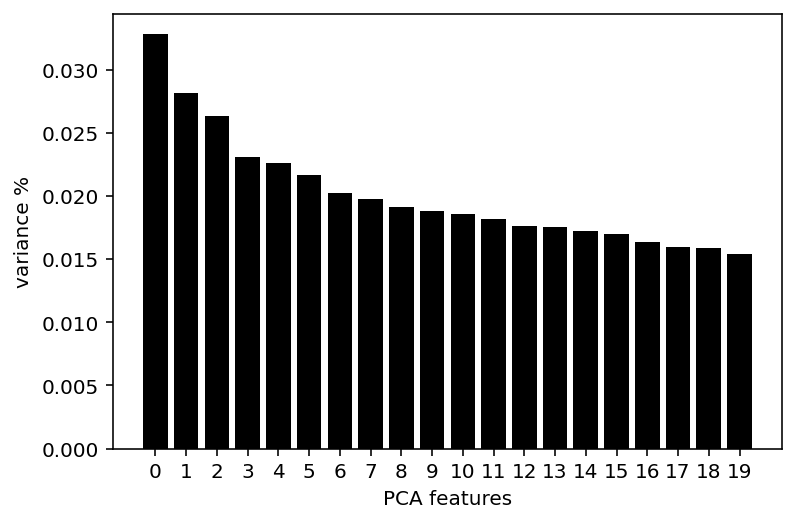

In [912]:
#Apply Principal Component Analysis for dimensionality reduction
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features)
features = range(pca.n_components_)

# Plot the explained variances
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

We have a bit of a drop in variance after the first three components which means we we can plot the first three components and see a good amount of the overall variance.

In [913]:
pca_df=pd.DataFrame(principalComponents)
pca_df.insert(loc=0,column='Neighborhood',value=neigh_df['Neighborhood']+', '+neigh_df['City']+', '+neigh_df['State'])
fig=px.scatter_3d(pca_df,x=0,y=1,z=2,hover_name='Neighborhood')
fig.show()

## 3 Training the K-Means Clustering Model

### 3.1 Find the best parameter k (number of clusters)
After eliminating 480 neighborhoods with less than 15 venues, we're left with 107 neighborhoods to cluster. We will apply the k-means clustering algorithm over a range of cluster counts k and measure inertia each time.  Then we plot the inertia of each k cluster count below to determine the best quality cluster model.

In [914]:
kmin=3
kmax=25

#Define a kmeans model
kmeans = KMeans(init='k-means++',random_state=1)
#Define an empty list to save error values (we will use the silhouette coefficient)
inertia_list = []
for k in range(kmin,kmax):
    kmeans.set_params(n_clusters=k)
    kmeans.fit(pca_df.iloc[:,1:4])
    inertia_list.append(kmeans.inertia_)
df=pd.DataFrame({'k':range(kmin,kmax),'inertia':inertia_list})

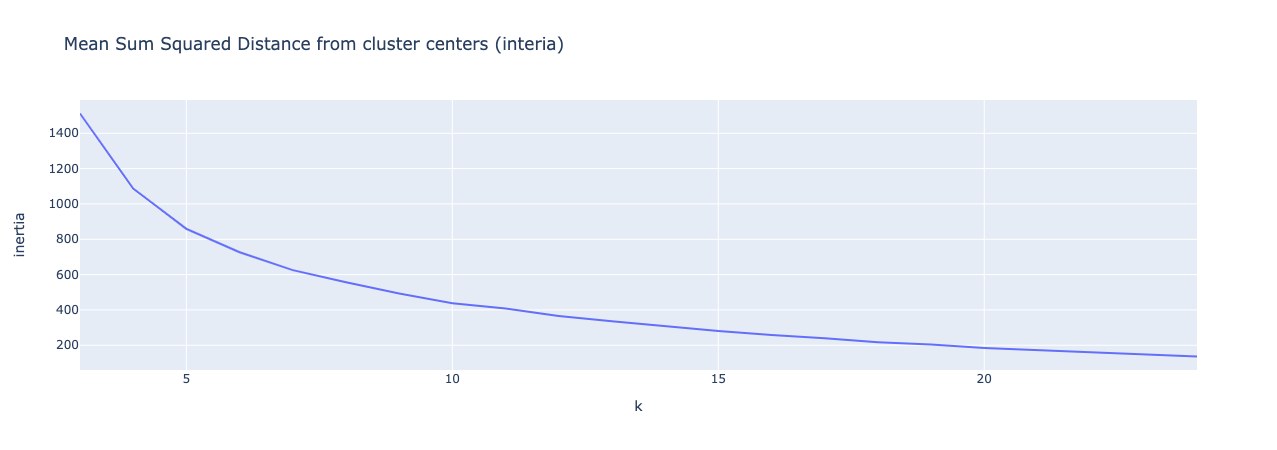

In [915]:
fig = px.line(df,x='k',y='inertia',title='Mean Sum Squared Distance from cluster centers (interia)')
fig.show()

It looks like the decrease in inertai really starts to level off around where k=5 which indicates diminishing returns.  Let's choose to make 5 clusters.

### 3.2 Fitting The K-Means Model

In [916]:
kmeans = KMeans(init="k-means++", n_clusters=5,random_state=1)
kmeans.fit(pca_df.iloc[:,1:4])

KMeans(n_clusters=5, random_state=1)

We can plot our data with reduced dimensionality again, this time with the results of our clustering respented in color.

In [918]:
fig = px.scatter_3d(pca_df, x=0,y=1, z=2, color=kmeans.labels_,hover_name='Neighborhood')
fig.show()

We can take a closer look at our clusters when we add our cluster labels to the neigh_df dataframe.

In [919]:
neigh_df.insert(loc=6, column='Cluster Label', value= kmeans.labels_)

In [920]:
neigh_df.loc[neigh_df['Neighborhood']=='Church Hill']

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
18,Church Hill,Richmond,VA,37.53284,-77.416252,15,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Church Hill was put into cluster 3 which appears magenta in the plot above.  Let's look at all the neighborhoods in cluster 3.

In [921]:
neigh_df.loc[neigh_df['Cluster Label']==3]

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
1,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arts District,Richmond,VA,37.543453,-77.438963,23,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bellevue,Richmond,VA,37.590832,-77.457554,15,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667
6,Bromo Arts District,Baltimore,MD,39.294943,-76.619813,22,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Brooklyn,Charlotte,NC,35.220105,-80.841931,73,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.013699
9,Canton,Baltimore,MD,39.282183,-76.576276,16,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,Capitol Hill,Washington,DC,38.886043,-76.999525,20,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,Cathedral Hill,Baltimore,MD,39.299596,-76.617173,33,3,0.0,0.0,0.030303,...,0.000000,0.0,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000
15,Charles Center,Baltimore,MD,39.289391,-76.615686,31,3,0.0,0.0,0.000000,...,0.032258,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,Church Hill,Richmond,VA,37.532840,-77.416252,15,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Of the 107 neighborhoods we considered, 49 of them were clustered with Church Hill into cluster 2.

In [922]:
neigh_df.groupby('Cluster Label').count()[['Neighborhood']]

,Neighborhood
Cluster Label,
0,8
1,28
2,17
3,50
4,3


In [923]:
neigh_df_clustered=neigh_df
neigh_df_clustered.to_csv('neigh_df_clustered.csv',index=False)

## 4 Anaysis and Determining New Retail for Church Hill

In [951]:
neigh_df=pd.read_csv('neigh_df_clustered.csv')

In [972]:
def plot_missing(df,neigh_name,cluster_num):
    neigh_freq=df.loc[df['Neighborhood']==neigh_name].iloc[:,7:]
    cluster_df=df.groupby('Cluster Label')[df.columns[7:]].mean().iloc[cluster_num,:].to_frame()
    cluster_df.insert(loc=1,column=neigh_name,value=neigh_freq.T)
    cluster_df=cluster_df.sort_values(by=cluster_num,ascending=False)[0:60]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
    x=cluster_df.index,
    y=cluster_df[cluster_num],
    name=str(['Cluster ',cluster_num]),
    ))
    fig.add_trace(go.Bar(
    x=cluster_df.index,
    y=cluster_df[neigh_name],
    name=neigh_name,
    opacity=0.7
    ))

    fig.update_layout(barmode='overlay')
    fig.show()

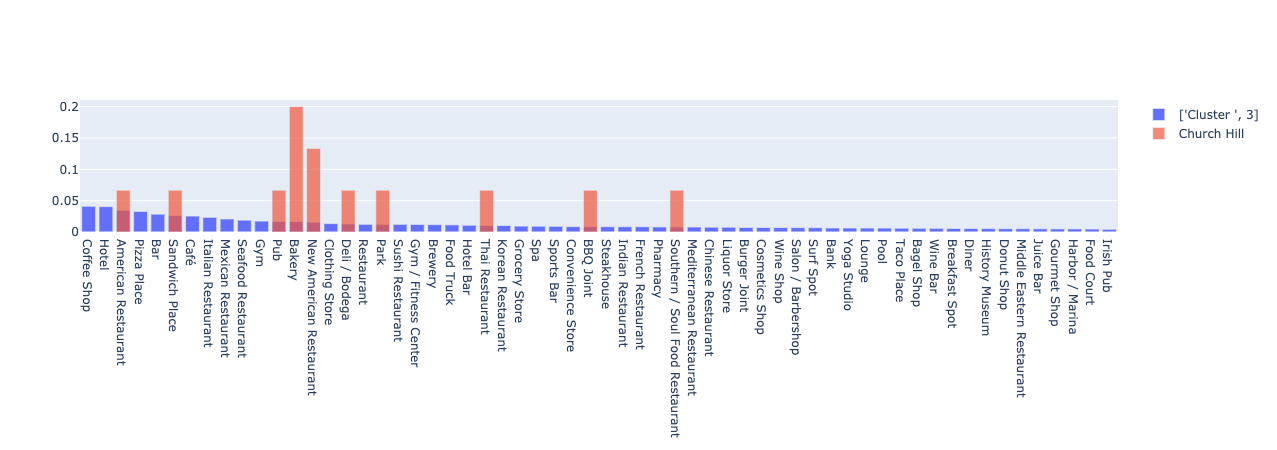

In [987]:
plot_missing(neigh_df,'Church Hill',3)